This notebook requires the following Julia packages:

DifferentialEquations, Flux, DiffEqFlux, Optim, DiffEqSensitivity, Plots, OrdinaryDiffEq, Zygote, StaticArrays, LinearAlgebra, BenchmarkTools, PaddedViews, LaTeXStrings, PGFPlotsX, PlotThemes, ApproxFun, SpecialFunctions, IJulia, ProgressMeter, SparseArrays





Some of these packages may have external dependencies. We refer to the documentation of each package, which can be accessed through https://juliapackages.com Once these external dependencies are met, the required packages can be installed by running the following Julia code:

```
using Pkg;
Pkg.install(["DifferentialEquations", "Flux", "DiffEqFlux", "Optim", "DiffEqSensitivity", "Plots", "OrdinaryDiffEq", "Zygote", "StaticArrays", "BenchmarkTools", "PaddedViews", "LaTeXStrings", "PGFPlotsX", "PlotThemes", "ApproxFun", "SpecialFunctions", "IJulia", "ProgressMeter", "SparseArrays"]);
```

In [1]:
#using Pkg;
#Pkg.install(["DifferentialEquations", "Flux", "DiffEqFlux", "Optim", "DiffEqSensitivity", "Plots", "OrdinaryDiffEq", "Zygote", "StaticArrays", "BenchmarkTools", "PaddedViews", "LaTeXStrings", "PGFPlotsX", "PlotThemes", "ApproxFun", "SpecialFunctions", "IJulia", "ProgressMeter", "SparseArrays"]);

In [2]:
using DifferentialEquations, Flux, DiffEqFlux, Optim, DiffEqSensitivity, Plots, OrdinaryDiffEq, Zygote, StaticArrays, LinearAlgebra, BenchmarkTools, PaddedViews, LaTeXStrings, PGFPlotsX, PlotThemes, ApproxFun, SpecialFunctions, IJulia, ProgressMeter, SparseArrays

In [3]:
pgfplotsx();
Plots.PGFPlotsXBackend();

push!(PGFPlotsX.CUSTOM_PREAMBLE, "\\usepackage{amsfonts,amssymb,amsmath,mathrsfs,amsbsy}");

## Define the coupled ODE Eq. (3) and the cost function $\mathcal C$ Eq. (4)

In [4]:
const σ0 = Hermitian(Complex{Float64}[1 0; 0 1]);
const σx = Hermitian(Complex{Float64}[0 1; 1 0]);
const σy = Hermitian(Complex{Float64}[0 -im; im 0]);
const σz = Hermitian(Complex{Float64}[1 0; 0 -1]);

Define a neural network $t \to \mathbf{p}(t)$ with two hidden layers of size 32, which seem to be sufficient for this problem

In [5]:
Ωp_nn = FastChain(FastDense(1,32), FastDense(32,32,tanh), FastDense(32,32,tanh), FastDense(32,6))
θ_transmon = initial_params(Ωp_nn);

In [6]:
# useful operators, such as creation (at) and annihilation (a), for the transmon Hamiltonian, truncated to N=4 levels.
const N=4;
const a = (sparse([i for i=1:N-1],[i for i=2:N],[√i+0im for i=1:N-1], N, N));
const at = (sparse([i for i=2:N],[i for i=1:N-1],[√i+0im for i=1:N-1], N, N));
const a0 = Diagonal(sparse([i for i=1:N],[i for i=1:N],[1.0+0im for i=1:N], N, N));
const n = Diagonal(at*a);
const η = Diagonal(at*at*a*a); # = at*a*(at*a-id)
const P = Diagonal(sparse([i for i=1:2],[i for i=1:2],[1.0+0im for i=1:2], N, N)); # projection operator, \mathcal P
const id = Matrix{Complex{Float64}}(I, N, N); # identity


const tol = 1e-7; # tolerance parameter for the ODE solver


# anharmonicity, sets the energy scale for all other parameters
const Δ = -2π*0.2;

# maximum allowed amplitudes for driving terms, in units of |Δ|
const Ωmax = 2.0;
const δmax = 2.0

# predefine constant terms in the Hamiltonian
const HΔ_N = (Δ/2)*η;
const Hϵ_N = Δ*n;

# pulse duration, in units of 2π/|Δ|
const T = 10.0;
tspan = (0.0, T);

# target unitary is a X_{-π/2} rotation
const θ = -π/2;
const Utarget = cos(θ/2)*σ0 + sin(θ/2)im*σx;

# parameters for the envelope A(t), which ensures (i) the driving vanishes at t=0 and t=T (ii) ramping is smooth / non-abrupt
const steepness = 2*T
smooth_square_envelope(t) = coth(steepness/4)*( tanh(steepness*t/(4*T)) - tanh(steepness*(t-T)/(4*T)) ) - 1;

# returns the RHS of Eq. (4)
function schrodinger_transmon_nn(u, p, t)
    @views @inbounds U = u[1:N, 1:N];
    envelope = smooth_square_envelope(t);


    # feed normalized time $t/T$ to the DNN, the output $\boldsymbol p(t)$ is used to construct the control Hamiltonian, as described in the main text
    # notational difference: Ωx and Ωy here corresponds to $\Omega_i/2$ in the text
    @views @inbounds nn_output = Ωp_nn([t/T],p);
    @inbounds Ωx, Ωy, δ = Ωmax*(2/π)*envelope*( atan(nn_output[1])*sin(nn_output[2]) ), Ωmax*(2/π)*envelope*(atan(nn_output[3])*sin(nn_output[4]) ), δmax*(2/π)*envelope*atan(nn_output[5])*sin(nn_output[6]) 
    Ω = Ωx - im*Ωy;
    Ωconj = Ωx + im*Ωy;
    local H = Hermitian(a*Ω + at*Ωconj + δ*n + HΔ_N);

    # $\mathcal E$ sensivity to errors in qubit frequency $\propto a^\dagger a$
    @inbounds local dℰ = U'*(Hϵ_N)*U;
    
    # RHS of Eq. (4)
    return [-(im*H)*U; dℰ]
end

const u0_transmon = Complex{Float64}[id; 0*id]; # initial condition to Eq. (4)
# specification of the ODE problem Eq. (4) using DifferentialEquations.jl
# further documentation is available at https://diffeq.sciml.ai/stable/tutorials/ode_example/
ode_transmon_nn = ODEProblem(schrodinger_transmon_nn, u0_transmon, tspan, θ_transmon);

# cost function, Eq. (3)
function cost_adjoint_transmon_nn(p, w=1.0)
    local ode_sol = solve(ode_transmon_nn, BS5(), p=Complex{Float64}.(p), abstol=tol, reltol=tol) # solve Eq. (4)
    local usol = last(ode_sol) # get solution of Eq. (4) at t=T

    @views @inbounds local Ugate = usol[1:2, 1:2]; # $\mathcal P U(T) \mathcal P$ in Eq. (3)
    @views @inbounds local ℰ = usol[N+1:N+2, 1:2]; # left portion of $\mathcal P ℰ(T)$ (the part in the computational block)
    @views @inbounds local ℰleak = usol[N+1:N+2, 3:N]; # remainder of $\mathcal P ℰ(T)$
    
    @inbounds local loss = abs(1.0 - (abs(tr(Ugate*Utarget')/2) )) + w^2 * ((norm( ℰ-(tr(ℰ)/2)*σ0 )/2)^2 + 2*norm(ℰleak)^2/8)  # Eq. (3)
    return loss

end

cost_adjoint_transmon_nn (generic function with 2 methods)

In [7]:
# keep track of cost function history, for plotting later on

cost_history = Float64[];
function cost_cb(p,l)
    append!(cost_history, l)
    return l < tol
end

ProgressMeter.ijulia_behavior(:clear)
bfgs_steps = 0;
function cost_cb_display(p,l, progress) # progress=true doesn't work with BFGS solver, so we add a progress bar manually
    append!(cost_history, l)
    IJulia.clear_output()
    global bfgs_steps
    bfgs_steps = bfgs_steps+1
    next!(progress, showvalues = [(:step, bfgs_steps), (:loss,l)])
    return l < tol # exit early if $\mathcal C$ is less than the ODE solver tolerance
end

cost_cb_display (generic function with 1 method)

## Minimize the cost function

In [8]:
# optimize the DNN using AMSGrad optimizer

nn_sol = DiffEqFlux.sciml_train(p -> cost_adjoint_transmon_nn(p, 0.01), θ_transmon, AMSGrad(0.001), maxiters = 200, progress=true, cb = cost_cb);

loss: 0.00316: 100%|████████████████████████████████████| Time: 0:02:37


In [9]:
# further refine the output using BFGS optimizer

progress = Progress(350)
nn_sol = DiffEqFlux.sciml_train(p -> cost_adjoint_transmon_nn(p, 0.01), nn_sol.minimizer, BFGS(initial_stepnorm=1e-3), maxiters = 350, cb = (p,l) -> cost_cb_display(p,l,progress), allow_f_increases=true);

In [10]:
transmon_nn_solution = nn_sol.minimizer;

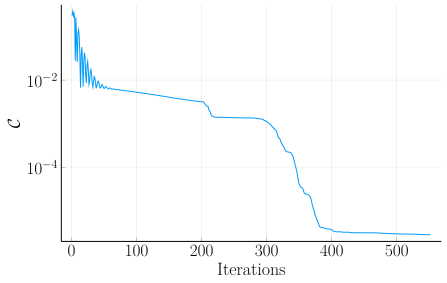

In [23]:
Plots.plot(cost_history, label=L"\mathcal C", ylabel=L"\mathcal C", xlabel=L"\text{Iterations}", xtickfont=18, ytickfont=18, legendfont=18, yscale=:log10, guidefont=18, legend=false)

In [24]:
savefig("transmon-cost.pdf")

## Optimized robust pulse shape

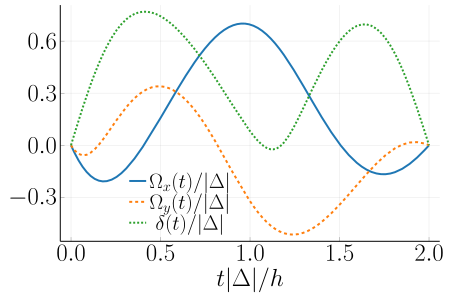

In [35]:
# returns the control fields Ωx(t), Ωy(t), δ(t) for a given DNN state p
function Ωxy(t,p)
    envelope = smooth_square_envelope(t);
    nn_output = Ωp_nn([t/T],p);
    @inbounds Ωx, Ωy, δ = Ωmax*(2/π)*envelope*atan(nn_output[1])*sin(nn_output[2]), Ωmax*(2/π)*envelope*atan(nn_output[3])*sin(nn_output[4]), δmax*(2/π)*envelope*atan(nn_output[5])*sin(nn_output[6])
    return [Ωx, Ωy, δ]
end

const fonstsize = 24;
theme(:default)

# plot the optimized control fields $\Omega_i(t)$ and $\delta(t)$
Plots.plot(τ -> 2*Ωxy(τ / (abs(Δ)/(2π)), transmon_nn_solution)[1]/abs(Δ), 0, T*abs(Δ)/(2π), label = L"\Omega_x(t)/|\Delta|", xlabel = L"t |\Delta|/h", xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-2), lw=2, palette = :tab10, legend = (0.17, 0.31), bg_legend=:transparent, fg_legend = :transparent) # bg_legend=:transparent, fg_legend = :transparent
Plots.plot!(τ -> 2*Ωxy(τ / (abs(Δ)/(2π)), transmon_nn_solution)[2]/abs(Δ), 0, T*abs(Δ)/(2π), label = L"\Omega_y(t)/|\Delta|", lw=2, line=(2, :dash) )
Plots.plot!(τ -> Ωxy(τ / (abs(Δ)/(2π)), transmon_nn_solution)[3]/abs(Δ), 0, T*abs(Δ)/(2π), label = L"\delta(t)/|\Delta|", lw=2, line=(2,:dot))

In [36]:
savefig("transmon-pulse.pdf")

## Verification of the robustness

### Calculate infidelity as a function of qubit frequency noise (in units of $\Delta$), using $N=10$ levels, compare against half-DRAG

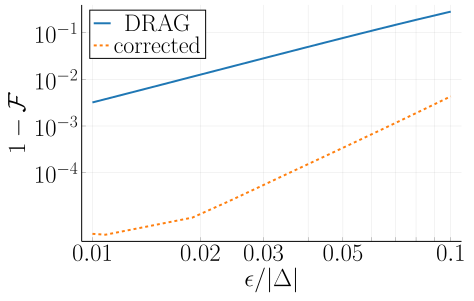

In [27]:
# slightly modified version of schrodinger_transmon_nn above, for verification purposes

const N=10;
const a = (sparse([i for i=1:N-1],[i for i=2:N],[√i+0im for i=1:N-1], N, N));
const at = (sparse([i for i=2:N],[i for i=1:N-1],[√i+0im for i=1:N-1], N, N));
const a0 = Diagonal(sparse([i for i=1:N],[i for i=1:N],[1.0+0im for i=1:N], N, N));
const n = Diagonal(at*a);
const η = Diagonal(at*at*a*a);
const P = Diagonal(sparse([i for i=1:2],[i for i=1:2],[1.0+0im for i=1:2], N, N));
const id = Matrix{Complex{Float64}}(I, N, N);


function schrodinger_transmon_check(U, err, t)
    envelope = smooth_square_envelope(t);
    @views @inbounds nn_output = Ωp_nn([t/T],transmon_nn_solution);
    @inbounds Ωx, Ωy, δ = Ωmax*(2/π)*envelope*atan(nn_output[1])*sin(nn_output[2]), Ωmax*(2/π)*envelope*atan(nn_output[3])*sin(nn_output[4]), δmax*(2/π)*envelope*atan(nn_output[5])*sin(nn_output[6])
    Ω = (Ωx - im*Ωy);
    Ωconj = (Ωx + im*Ωy);
    local Herr = Hermitian(a*Ω + at*Ωconj + (Δ*err + δ)*n + (Δ/2)*η);
    return -im*Herr*U
end

const U0_transmon = id;

ode_transmon_check = ODEProblem(schrodinger_transmon_check, U0_transmon, tspan);

function infidelity(err)
    ode_sol = solve(ode_transmon_check, BS5(), p=err, abstol=tol, reltol=tol);
    Ugate = last(ode_sol);
    F = tr(Ugate[1:2,1:2]*Utarget')/2;
    return abs(1.0 - abs(F)^2);
end


# fidelity of the fastest (within the allowed infidelity budget) "half-DRAG" pulse,
# given in Eq. (4.34) and Eq. (3.2) of Phys. Rev. A 83, 012308 (2011)
function infidelity_drag(ϵ, Σ=0.53, θ=-π/2)
    local σ = abs(2π*Σ/Δ);
    local tg = 4σ;
    local Ωg(t) = -θ*(  exp(-((t-tg/2)/(σ*√2))^2) - exp(-tg^2/(8*σ^2)) )  /    (  √(2π*σ^2)*erf(tg/(σ*√8)) - tg*exp(-tg^2/(8*σ^2)) ); # Eq. (3.2)
    local ΩDRAG(t) = Ωg(t) + im*Ωg'(t)/(2Δ); # Eq. (4.34)
    

    # solve the time-dependent Schrodinger equation with qubit frequency noise ϵ to obtain infidelity
    local function schrodinger_DRAG(U,p,t)
            local Ω = ΩDRAG(t)/2
            local Ωconj = conj(Ω);
            local δ = 0.0;
            local Herr = Hermitian(a*Ω + at*Ωconj + (Δ*ϵ + δ)*n + (Δ/2)*η);
            return -im*Herr*U;
    end

    local Ugate = last( solve(ODEProblem(schrodinger_DRAG, U0_transmon, (0,tg)), BS5(), abstol=tol, reltol=tol) )[1:2,1:2]
    return 1.0 - abs(tr(Ugate*Utarget')/2)^2
    
end

Plots.plot(infidelity_drag, 1e-2, 1e-1, label="DRAG", ylabel=L"1-\mathcal F", xlabel=L"\epsilon/|\Delta|", xaxis=:log10, yaxis=:log10, xticks=(1e-2:1e-2:1e-1, [L"0.01",L"0.02",L"0.03",L"",L"0.05",L"",L"",L"",L"",L"0.1"]), xformatter=LaTeXStrings.latexstring, yticks=([1e-4,1e-3,1e-2,1e-1], [L"10^{-4}",L"10^{-3}",L"10^{-2}",L"10^{-1}"]), yformatter=LaTeXStrings.latexstring, xtickfont=font(fonstsize-0), ytickfont=font(fonstsize-0), guidefont=font(fonstsize-0), legendfont=font(fonstsize-0), lw=2, palette = :tab10, legend=:topleft )
Plots.plot!(infidelity, 1e-2, 1e-1, label="corrected", lw=2, palette = :tab10, line=(2,:dash))

In [28]:
savefig("transmon-fidelity.pdf")

## Get an approximation of the pulse shape using Chebyshev polynomials

In [14]:
ΩxbyΔApprox = Fun(t -> 2*Ωxy(t, transmon_nn_solution)[1]/abs(Δ), Chebyshev(Interval(0,T) ) );
ΩybyΔApprox = Fun(t -> 2*Ωxy(t, transmon_nn_solution)[2]/abs(Δ), Chebyshev(Interval(0,T) ) );
δbyΔApprox = Fun(t -> Ωxy(t, transmon_nn_solution)[3]/abs(Δ), Chebyshev(Interval(0,T) ) );

In [15]:
# get Chebyshev approximation with 0.01 accuracy, then keep only 4 digits for readability the paper
# further details on Chebyshev approximation can be found on https://juliaapproximation.github.io/ApproxFun.jl/latest/

ΩxbyΔApproxChop = Fun(Chebyshev(Interval(0,T)), round.(coefficients(chop(ΩxbyΔApprox, 0.01)),digits=4) );
ΩybyΔApproxChop = Fun(Chebyshev(Interval(0,T)), round.(coefficients(chop(ΩybyΔApprox, 0.01)),digits=4) );
δbyΔApproxChop = Fun(Chebyshev(Interval(0,T)), round.(coefficients(chop(δbyΔApprox, 0.01)),digits=4) );

In [16]:
println(ΩxbyΔApproxChop);
println(ΩybyΔApproxChop);
println(δbyΔApproxChop);

Fun{Chebyshev{IntervalSets.ClosedInterval{

Float64}, Float64}, Float64, Vector{Float64}}(Chebyshev(0.0..10.0), [0.0896, -0.0045, -0.3104, 0.0468, 0.2515, -0.0417, -0.035, -0.0029, 0.0061, 0.003, -0.0021])
Fun{Chebyshev{IntervalSets.ClosedInterval{Float64}, Float64}, Float64, Vector{Float64}}(Chebyshev(0.0..10.0), [-0.0547, -0.1069, 0.1036, 0.232, -0.1025, -0.1269, 0.0551, 0.0043, -0.0022, -0.0047, 0.002, 0.0024, -0.0015])
Fun{Chebyshev{IntervalSets.ClosedInterval{Float64}, Float64}, Float64, Vector{Float64}}(Chebyshev(0.0..10.0), [0.3713, -0.0351, -0.1123, 0.0698, -0.3277, -0.0625, 0.076, 0.0442, -0.0091, -0.0253, 0.0017, 0.0137, 0.0015, -0.0074, -0.0028, 0.0038, 0.0026, -0.0016, -0.0021])


In [17]:
ΩxApproxChop(t) = ΩxbyΔApproxChop(t)*abs(Δ);
ΩyApproxChop(t) = ΩybyΔApproxChop(t)*abs(Δ);
δApproxChop(t) = δbyΔApproxChop(t)*abs(Δ);

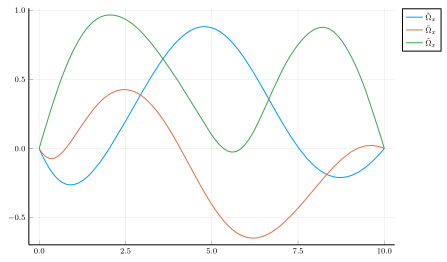

In [18]:
Plots.plot([ΩxApproxChop,ΩyApproxChop,δApproxChop],0,T,label=[L"\tilde\Omega_x",L"\tilde\Omega_y",L"\tilde\delta"])

### Verify that the Chebyshev approximation hasn't altered the fidelity/robustness

In [29]:
function schrodinger_transmon_check_approx(U, err, t)
    @inbounds Ωx, Ωy, δ = ΩxApproxChop(t), ΩyApproxChop(t), δApproxChop(t)
    Ω = (Ωx - im*Ωy)/2;
    Ωconj = (Ωx + im*Ωy)/2;
    local Herr = Hermitian(a*Ω + at*Ωconj + (Δ*err + δ)*n + (Δ/2)*η);
    return -im*Herr*U
end

ode_transmon_check_approx = ODEProblem(schrodinger_transmon_check_approx, U0_transmon, tspan);

function infidelity_approx(err)
    ode_sol = solve(ode_transmon_check_approx, BS5(), p=err, abstol=tol, reltol=tol)
    Ugate = last(ode_sol)[1:2,1:2]
    return abs(1.0 - abs(tr(Ugate*Utarget[1:2,1:2]')/2)^2)
end

infidelity_approx (generic function with 1 method)

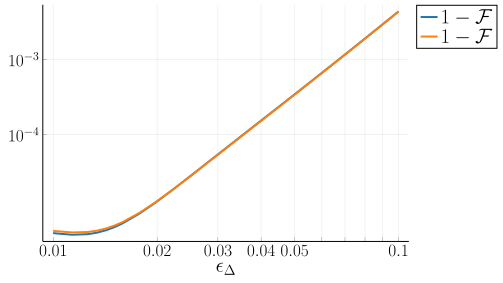

In [30]:
Plots.plot([infidelity,infidelity_approx], 1e-2, 1e-1, label=L"1-\mathcal F", xlabel=L"\epsilon_\Delta", xaxis=:log10, yaxis=:log10, xticks=(1e-2:1e-2:1e-1, [L"0.01",L"0.02",L"0.03",L"0.04",L"0.05",L"",L"",L"",L"",L"0.1"]), xformatter=LaTeXStrings.latexstring, yticks=([1e-4,1e-3,1e-2,1e-1], [L"10^{-4}",L"10^{-3}",L"10^{-2}",L"10^{-1}"]), yformatter=LaTeXStrings.latexstring, xtickfont=font(fonstsize-6), ytickfont=font(fonstsize-6), guidefont=font(fonstsize-2), legendfont=font(fonstsize-2), lw=2, palette = :tab10  )

In [31]:
savefig("transmon-fidelity-chopped.pdf")

## Print out full array of the the opimized and initial DNN parameters

In [32]:
print(transmon_nn_solution)

Float32[-0.97915673, -0.36460218, -0.79033154, 0.8239472, 1.0524946, -0.67725754, -0.66329354, 0.28241038, -1.092163, -0.5660408, -0.26786017, -0.21756597, 0.121958114, 0.22800055, 0.8166376, 0.5764276, -0.19596633, -0.53310657, -0.12392185, -0.59142804, 0.45606706, 0.42802846, -0.041787006, -0.07146492, -0.08107781, -0.08068257, -0.11327824, 0.37855577, 0.0017870372, -0.1132204, -0.91454566, 0.66256756, -0.102426864, -0.055578172, 0.13265869, -1.0578063, -0.029647138, 0.0978467, -0.4962986, -0.16951257, 0.49278498, 0.24277303, -0.032765258, -0.5254691, 0.7005557, 0.67708355, -0.29841214, 0.08978837, -0.2520453, -0.16673256, -0.37952036, -0.30156913, -0.467737, -0.8299329, -1.1357589, 0.26708332, -0.89152116, 0.35940096, -0.5879611, -0.5834776, -0.40460023, 0.05868539, -0.28975445, -0.24679054, -0.08214806, -0.25520575, 0.13660981, -0.066546366, -0.22133252, -0.067704536, 0.26551285, 0.05319037, 0.28709376, -0.19153234, 0.27366552, 0.18434778, 0.20606251, 0.10280727, 0.052064214, 0.094

In [33]:
print(θ_transmon) # initial state of the DNN optimization parameters

Float32[-0.05793912, 0.09872318, -0.09859356, 0.39045578, -0.20371759, -0.36060742, -0.10171031, -0.28290418, -0.42234492, -0.29512975, 0.27883565, -0.22612186, 0.04487616, 0.023647808, 0.096561536, 0.2526414, -0.025700059, 0.18488246, -0.3188858, -0.25780535, 0.1406127, 0.40525666, -0.24050023, 0.1968992, 0.24629049, 0.16451782, -0.27556184, 0.009133011, -0.05999981, 0.08781555, -0.33608752, 0.41857845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.048313983, -0.30422136, 0.14395185, -0.14933783, -0.20998728, -0.034291834, 0.24481311, 0.01937338, 0.13179536, -0.21473253, 0.21108988, 0.16066618, 0.19974795, 0.06677252, -0.05078943, 0.051087637, 0.17170182, -0.10021842, -0.1335771, -0.02362011, 0.09341047, 0.038783114, 0.11844628, 0.10721866, 0.25361362, -0.0061017456, -0.058645964, 0.28839755, 0.13859442, 0.20011485, -0.21965554, 0.20222938, 0.30160743, 0.04268937, -0.13

## Load the optimized DNN parameters (useful for re-doing plots, etc)

In [ ]:
transmon_nn_solution = Float32[-0.97915673, -0.36460218, -0.79033154, 0.8239472, 1.0524946, -0.67725754, -0.66329354, 0.28241038, -1.092163, -0.5660408, -0.26786017, -0.21756597, 0.121958114, 0.22800055, 0.8166376, 0.5764276, -0.19596633, -0.53310657, -0.12392185, -0.59142804, 0.45606706, 0.42802846, -0.041787006, -0.07146492, -0.08107781, -0.08068257, -0.11327824, 0.37855577, 0.0017870372, -0.1132204, -0.91454566, 0.66256756, -0.102426864, -0.055578172, 0.13265869, -1.0578063, -0.029647138, 0.0978467, -0.4962986, -0.16951257, 0.49278498, 0.24277303, -0.032765258, -0.5254691, 0.7005557, 0.67708355, -0.29841214, 0.08978837, -0.2520453, -0.16673256, -0.37952036, -0.30156913, -0.467737, -0.8299329, -1.1357589, 0.26708332, -0.89152116, 0.35940096, -0.5879611, -0.5834776, -0.40460023, 0.05868539, -0.28975445, -0.24679054, -0.08214806, -0.25520575, 0.13660981, -0.066546366, -0.22133252, -0.067704536, 0.26551285, 0.05319037, 0.28709376, -0.19153234, 0.27366552, 0.18434778, 0.20606251, 0.10280727, 0.052064214, 0.094994724, 0.22856165, -0.14379366, -0.22872697, -0.014456553, 0.07187138, 0.0371128, 0.112539314, 0.10064531, 0.19689538, -0.0020610252, -0.12096475, 0.29144257, 0.15249452, 0.20276028, -0.20563132, 0.22866394, 0.33314592, 0.014638558, -0.15194164, -0.15112148, -0.1371953, 0.19742595, 0.2074348, 0.12895171, -0.027359193, -0.072949775, -0.08784431, -0.18322742, -0.3177911, 0.006933871, 0.12753946, -0.27811447, 0.105970666, 0.22148848, -0.041827146, 0.26644167, -0.15806358, 0.11336034, 0.27689958, -0.1118521, -0.17552564, 0.09914064, -0.16627455, -0.12885636, 0.21972306, -0.29217932, 0.19629166, 0.23329826, 0.2243951, 0.3027664, 0.15853857, -0.13471578, 0.24031909, -0.18972377, 0.26451075, 0.16383076, 0.25583336, -0.09726402, -0.08518301, 0.17385255, 0.021266684, 0.18563414, 0.3183929, -0.029747345, -0.12200181, -0.2298638, -0.26648998, -0.29805568, -0.09613084, 0.27698976, 0.2756614, 0.14168392, 0.01582085, -0.03530326, -0.120306656, -0.2157708, 0.0038134488, 0.20127779, 0.22219287, -0.06610236, 0.03660942, -0.3773173, -0.34013385, -0.37259, 0.33157942, 0.44116318, -0.07562609, -0.407768, -0.64364827, -0.113687895, -0.15206008, -0.2782017, -0.39741513, 0.07464066, -0.5667945, -0.05574257, -0.124508895, 0.20670338, 0.54690796, -0.3425474, 0.116081364, 0.09728687, 0.051595263, -0.34088168, 0.29014283, -0.2517255, -0.0043435935, -0.031307243, -0.29086924, -0.18589893, -0.014723242, 0.17179275, 0.18967183, 0.072458066, 0.09500447, 0.24460962, 0.07566676, -0.20711325, 0.24290688, 0.38391685, 0.04953463, -0.17696652, -0.1158114, 0.2130523, -0.1117546, 0.050366044, 0.010552503, -0.19602668, -0.11717528, 0.092060365, 0.085322276, 0.22916351, -0.08354085, -0.108310565, -0.16083163, 0.10498731, -0.28791794, -0.02798897, -0.020289328, -0.058983862, -0.23298799, 0.041829295, -0.09454775, -0.15196694, 0.2730523, 0.14747941, 0.1626726, 0.35111418, -0.26732737, -0.3559555, 0.34658343, 0.013549286, 0.9701247, 0.30978838, 0.066605456, -0.01653312, 0.03885224, -0.054184332, 0.36531875, 0.33648115, 0.24666929, -0.3946655, -0.13577472, 0.15764454, -0.16439329, -0.14143486, 0.040593967, -0.06433543, -0.39265049, -0.26178673, -0.11288978, 0.18325411, 0.19994065, 0.22746679, -0.09415721, -0.06206036, -0.1740263, 0.11151227, -0.16148968, 0.05728211, 0.18614687, -0.29546675, 0.23716964, 0.120513774, 0.5170878, 0.32679707, 0.19276826, -0.18502241, 0.029411497, 0.35736033, 0.34986594, -0.15522198, -0.24439785, 0.11506417, -0.100682884, -0.111894675, 0.08459633, 0.038861204, -0.11777096, -0.2395815, 0.023279522, -0.2138489, 0.086973436, -0.040084105, -0.120975, -0.031095216, 0.1994917, -0.18582256, -0.016934041, 0.06167423, -0.011903755, 0.12167064, 0.12861194, 0.06930953, 0.064329684, 0.028515978, 0.49666184, -0.16671513, 0.30986726, -0.21199149, 0.28616813, 0.15833484, 0.17302237, 0.3850532, 0.24217655, -0.39851993, -0.21637432, -0.03300654, 0.2313842, 0.12157619, -0.1873225, 0.076320566, -0.20190842, 0.28585488, -0.13928223, 0.10992527, 0.21255097, -0.011230036, -0.2876153, 0.023755357, -0.08324565, 0.21264397, -0.21441622, 0.6369597, -0.08446332, -0.19179547, 0.30732703, 0.5107761, 0.76429677, 0.15230852, 0.2105915, 0.35028538, 0.23167244, 0.46064645, 0.46083942, -0.03785677, 0.40570155, -0.46410224, -0.14052498, 0.025544254, 0.07342538, 0.02136824, -0.1715227, 0.16683973, -0.36938873, 0.09916577, -0.07355075, -0.16694015, 0.089100406, 0.4079818, -0.058908135, -0.32014623, 0.062162366, 0.14376794, 0.13683389, 0.51038843, 0.14702863, 0.08519571, 0.20301804, 0.20391439, 0.40388545, 0.104693025, 0.3135343, 0.21058202, 0.3378849, 0.44988215, 0.31963834, 0.2198691, 0.11124008, -0.34457776, -0.12947519, -0.09762021, -0.36278617, 0.049345423, 0.21236698, 0.22723275, -0.2213627, 0.16662407, -0.40966895, -0.096380875, -0.12750116, -0.0314294, -0.03553183, 0.2857673, -0.051864017, -0.27960476, -0.27598697, -0.35999146, 0.0713395, 0.15387234, 0.11801456, 0.04623001, -0.43850142, -0.27925983, -0.0964963, 0.05625121, -0.23156758, -0.0425101, -0.46821246, -0.33363804, -0.17580044, -0.08236892, 0.029429534, 0.2086173, 0.28688663, -0.036934115, -0.09854978, 0.0324378, 0.07978177, -0.15643422, 0.36584944, -0.1230579, 0.06352534, -0.018393124, -0.010463137, -0.26092377, 0.18980478, 0.31192592, 0.1552029, 0.41379863, 0.19938183, 0.18318644, 0.23600452, -0.14573729, 0.6263204, 0.072510526, 0.19031863, 0.0535974, 0.061966263, 0.4315893, -0.026414374, 0.15611637, 0.3118887, 0.10011269, 0.05911476, 0.25473315, 0.12305554, -0.048128106, -0.17990234, -0.036569204, -0.00025839527, -0.17738187, -0.28317666, 0.27193728, 0.051972613, -0.1085946, 0.10901649, 0.16076086, -0.0972404, 0.10307038, 0.011190501, 0.11540579, 0.27601683, -0.0055477154, -0.25511608, 0.030982316, -0.24083918, -0.17839175, 0.17883207, 0.14373064, -0.029059727, 0.16278444, 0.24537379, -0.1694325, 0.26627252, -0.17622443, -0.10621436, -0.2184632, 0.266978, -0.26671296, 0.16398504, -0.1786783, -0.014884497, 0.18550466, 0.22228141, -0.16704535, 0.0073255403, -0.29745704, 0.06532379, -0.1941867, 0.17743072, -0.26335657, 0.20673014, 0.2500578, -0.06559443, 0.18121183, -0.2756814, -0.19446722, -0.22935124, -0.12968175, 0.27133295, 0.21487059, 0.09315734, 0.044301048, -0.23329878, 0.09918444, -0.06004891, 0.11811787, 0.0016910697, 0.079977244, -0.23799968, -0.26416782, -0.030359894, 0.2905148, -0.27218437, -0.17179562, -0.15182231, -0.09231353, 0.077131815, -0.040263757, 0.23335129, -0.043954488, 0.102879494, -0.20634072, 0.10938647, 0.14658324, 0.14974774, -0.21631576, -0.3064885, -0.29435533, -0.4918428, -0.11892419, -0.36611035, 0.07552188, -0.19567272, -0.14170566, -0.27696282, 0.14864907, -0.29656738, 0.038729925, -0.17367564, -0.091627784, 0.01282934, 0.08372112, 0.21034014, -0.16369037, -0.20866063, -0.23387653, 0.16762635, -0.2929557, 0.23946744, 0.1934912, -0.2365066, -0.23684692, 0.26030195, -0.0043693706, -0.22311535, -0.28412738, 0.34543693, 0.14239542, 0.13869144, 0.0965722, -0.80167705, 0.08129873, -0.38498908, -0.35011077, -0.37945345, -0.25259954, -0.043280583, 0.15874931, 0.038241345, -0.05209535, 0.20013782, -0.3088601, 0.14887589, -0.2738174, 0.2410999, -0.25005054, 0.3065434, 0.122008644, -0.05619563, 0.21651497, -0.3141095, -0.22634284, 0.2637919, 0.12568168, 0.14396109, -0.10959071, 0.09029777, 0.06517529, 0.061577532, 0.070103146, 0.07688335, 0.09789772, 0.19688797, -0.2358633, 0.2924302, 0.028734758, 0.2485722, 0.1540734, 0.20959193, -0.16630426, -0.0803371, 0.18111812, 0.12339468, -0.13009074, -0.034030847, -0.19644763, -0.08627597, -0.16317837, -0.23250273, 0.0026418788, -0.19286992, 0.26664385, 0.2856976, -0.30276376, 0.07943427, 0.08721322, -0.20262614, -0.21889459, -0.26411414, -0.08366007, 0.023076864, 0.12989917, 0.1713192, -0.29654488, -0.14616846, -0.26402158, -0.0901871, 0.020564947, -0.14938548, 0.004801693, 0.13655756, -0.12158028, 0.08815646, 0.048636165, -0.15994869, -0.28598303, 0.13211244, 0.088030905, -0.06376831, -0.26396683, 0.2273755, -0.05035845, 0.31485108, 0.054664478, 0.289718, 0.14710289, -0.10573856, -0.1312163, -0.20370609, 0.2348091, -0.14483692, 0.2632718, -0.13732706, 0.019651776, 0.10810832, -0.10245054, 0.83824515, -0.11778027, 0.22792369, -0.2673041, 0.29011267, 0.42573577, 0.22573382, -0.051524453, 0.12411504, -0.23685548, -0.07734572, 0.3282728, -0.053076543, 0.10424494, -0.23225804, -0.23980443, 0.13523403, -0.12023046, -0.096260004, 0.18665771, 0.11060274, 0.40824035, 0.1605139, 0.11549595, 0.123277105, 0.017672976, -0.002952892, 0.22162294, 0.24333082, -0.10035746, 0.02879924, 0.031039527, 0.80118763, 0.38927308, 0.3805847, -0.09007524, 0.20814915, 0.2077579, -0.010304475, -0.12755369, 0.17777434, -0.19673046, -0.4578966, -0.10826468, 0.24338816, 0.110616215, -0.02454771, 0.15689667, -0.1804349, 0.25458246, -0.06980025, -0.17266546, 0.2125774, -0.045030486, -0.09537464, -0.00465043, 0.213867, 0.22740981, 0.07817336, -0.28473797, 0.050876845, 0.05862928, 0.023687182, 0.18413676, -0.38094035, -0.09938391, -0.32762265, -0.28194436, -0.076774545, 0.06352693, -0.27173775, -0.12358944, -0.4224628, 0.3554091, -0.14690846, -0.3238441, -0.061167598, 0.2809163, 0.19677259, -0.17456022, -0.21931247, -0.28921857, -0.089175545, -0.2896383, 0.11092034, 0.07562475, 0.2500027, 0.22788909, -0.019206477, -0.3536831, -0.21032676, -0.48649547, -0.09633581, 0.40673348, 0.18839054, -0.18000084, -0.78731984, 0.1898177, -0.010907211, -0.033367757, -0.057814058, -0.080106325, -0.6386681, -0.37551507, -0.3750471, 0.2967575, 0.046227545, -0.27048066, 0.076367155, -0.18299109, -0.13517664, -0.30267012, 0.2502043, -0.03840506, 0.053674124, 0.2663269, 0.15101054, -0.41405055, 0.116312936, 0.29194263, 0.2283789, -0.22306964, -0.13000473, -0.006672308, 0.13066523, -0.39705318, 0.042233486, 0.15026042, 0.5691735, -0.17513345, 0.28221738, 0.32174003, -0.16353215, 0.47214088, -0.028757358, -0.11171496, 0.35533684, -0.26671004, -0.43967575, -0.018123465, 0.08156632, 0.11107325, -0.14768805, -0.27290905, 0.1945387, -0.26235822, -0.23902111, -0.06664696, 0.20458364, -0.006359542, -0.11271216, 0.14662014, 0.15675165, 0.21655975, -0.21214312, 0.11935694, -0.18972948, 0.21787302, 0.093638934, 0.094904676, -0.65803003, 0.2012753, -0.36854348, 0.065839365, -0.08308193, 0.15283367, -0.06836088, 0.18745622, -0.29206496, 0.12649095, 0.13826685, -0.018093947, -0.10716863, -0.05556255, 0.062457778, -0.24626397, -0.18166424, 0.081512384, 0.19787067, -0.15630236, -0.2908365, 0.10465926, -0.08676079, -0.3083576, 0.0021397737, -0.15692289, -0.030489579, -0.31704056, -0.1866763, -0.06149384, -0.16862096, -0.036442943, -0.21266091, -0.1373332, -0.07609056, -0.05338477, -0.015994826, 0.12194023, -0.3863001, -0.29604703, -0.36497822, 0.09771558, 0.11206143, -0.24414812, 0.3138052, 0.28577742, -0.10422006, 0.0073908614, 0.22774498, -0.32923776, -0.07635989, -0.26404852, -0.27262253, -0.11503191, 0.061880603, -0.014859085, -0.2212858, 0.010088148, -0.016882207, -0.024481948, -0.08465994, 0.078009106, 0.14873976, 0.007481066, -0.3464186, -0.32250097, 0.03586592, 0.17341867, -0.092627466, -0.037522092, -0.1453418, -0.0932284, 0.04617767, -0.10751384, 0.3102291, -0.27021393, 0.31234962, 0.111209214, 0.21623124, 0.09181689, 0.30928156, 0.20580484, -0.0034737743, -0.004609727, -0.17140482, -0.04004232, 0.17712587, 0.13657159, 0.24971144, 0.024304293, -0.070291035, 0.34267184, 0.17194189, -0.30995402, 0.016209725, 0.39690956, 0.46381453, 0.32480988, 0.48409382, 0.1366264, 0.15951318, 0.14642689, 0.14338169, 0.013839993, 0.25548756, -0.028124116, -0.10341065, 0.1865411, 0.16120815, 0.06542617, -0.19763948, 0.0055874866, -0.020650802, -0.06391539, -0.08102913, -0.013488238, 0.2769135, 0.19918647, -0.18334906, 0.2360704, 0.067811325, -0.26794067, -0.039317954, -0.14640506, 0.124474786, -0.28625804, -0.28894183, -0.1070957, 0.09808389, -0.2200294, -0.2564601, 0.07084596, -0.22026686, 0.02165714, -0.052229244, -0.08986744, -0.23157085, -0.19420725, 0.24170601, 0.15520485, 0.24931675, -0.22782223, 0.15007563, 0.0061572636, 0.0012732579, -0.09020855, -0.18138297, 0.096437745, 0.04358324, 0.02561618, -0.21843645, -0.16770685, -0.013900454, 0.002923739, -0.3017938, -0.13335584, 0.14629354, 0.09650733, -0.16612199, -0.23348247, 0.29526398, -0.06237047, -0.20151314, 0.04211746, 0.04088516, -0.11856775, 0.031136334, 0.2817413, -0.032879535, 0.05669077, -0.24328496, 0.019471245, 0.12610112, 0.1720189, -0.020522568, 0.054880746, 0.15247735, 0.21542987, 0.039079245, 0.04972087, -0.24837674, 0.022177435, -0.17958607, 0.24055836, -0.15559737, 0.23151703, 0.21412952, -0.12842968, 0.18318766, -0.20990108, -0.12676749, -0.11783349, -0.014119741, -0.19734004, 0.059092373, -0.15240076, -0.15397796, 0.12371595, -0.31895894, -0.009200173, -0.22810392, 0.15847768, 0.10686018, -0.109597266, -0.08821523, 0.108727954, -0.2278709, -0.25729772, -0.11778751, 0.09561576, 0.20258598, -0.21739464, -0.06982148, 0.20859677, 0.043085117, -0.18048838, 0.025698585, -0.052388612, 0.27148083, 0.28327036, -0.108058915, -0.24578469, 0.29861787, 0.36393684, 0.8554425, 0.046966158, 0.41825885, 0.3388364, -0.13759121, 0.23596182, 0.40756872, -0.030803425, 0.14127846, -0.30733547, -0.19796692, -0.06738828, -0.17546667, 0.2702531, 0.2451145, -0.10982396, -0.0031003153, -0.02701203, -0.16206881, -0.23362578, 0.12652728, 0.34322873, -0.3594701, -0.23573314, 0.019198392, 0.01975468, 0.20999105, -0.36254117, 0.22357135, 0.39682427, 0.042862236, -0.41448334, -0.97328687, -0.4186653, -0.43339396, 0.2197106, -0.11404321, -0.14733604, -0.56404185, -0.16275927, -0.43536308, 0.37149352, 0.33416718, -0.31858796, 0.09317467, -0.30362958, 0.19476117, -0.25323334, 0.083337985, 0.0910837, 0.046803672, -0.3410018, -0.032021347, -0.12303005, 0.10416422, 0.30730784, -0.29623902, 0.22473194, 0.28704017, 0.5479177, -0.22615826, -0.087761976, -0.11178499, 0.47666565, -0.118180476, -0.16822198, 0.2462353, 0.22538547, 0.1668019, -0.09811401, 0.41601464, 0.59761775, 0.7863427, -0.15194595, 0.14047463, 0.2286565, -0.43911833, -0.5260114, 0.14046045, 0.7241394, -0.36317933, 0.55344534, 0.60976297, -0.012921167, 0.119951695, 0.49099052, 0.7408507, -0.49878418, -0.15954822, 0.18654604, 0.08581976, -0.11288393, -0.12654036, 0.15568495, -0.3542906, -0.13970862, -0.07300315, -0.38822988, 0.05385103, 0.07642305, 0.12028592, 0.24264151, -0.09574146, 0.29192904, 0.2312504, 0.06404662, -0.3711992, -0.19542521, 0.47785848, -0.012533592, 0.033427037, -0.58970255, 0.039246526, -0.08957892, -0.042614695, -0.23558304, -0.3252757, -0.04224711, -0.19898465, -0.38301682, 0.2588443, -0.18514588, -0.03036259, 0.1303451, 0.08517812, -0.06536882, 0.08735424, 0.074915834, -0.11823554, -0.03615322, 0.30315956, 0.16053227, -0.024790041, 0.29633653, -0.078934126, 0.118278235, -0.136791, -0.2489335, -0.05290041, 0.021716287, 0.31531537, -0.13594243, 0.23949498, -0.26146185, 0.20917515, 0.31509522, -0.068687305, 0.16777515, 0.061320066, 0.18202475, 0.24023755, 0.27261958, -0.25469232, 0.110859185, -0.058001842, 0.1341867, 0.1116198, -0.24763319, 0.13677248, 0.31673387, 0.24141318, -0.14522387, -0.28699812, 0.035243202, -0.24857813, 0.12828362, -0.1966984, -0.18983495, 0.04571465, 0.08152657, -0.021673368, -0.06682125, 0.0059428234, -0.034784243, 0.03160817, 0.24359559, -0.16765851, 0.21868756, -0.046194505, 0.32137161, 0.13332434, -0.18315497, 0.0018591909, -0.14390726, -0.010391528, 0.36654216, 0.42947346, 0.3160468, -0.30639333, -0.3078323, 0.02719436, 0.027973736, 0.045478933, -0.4100461, -0.10227545, -0.04759603, 0.12647295, 0.2738374, -0.035109624, -0.2977568, -0.017079715, -0.36861295, -0.48675728, 0.3506386, 0.25035846, -0.023694746, -0.18913719, -0.55720454, -0.080486365, 0.47732985, 0.092562184, -0.28538382, -0.249158, -0.00043369795, 0.06268079, -0.37855324, 0.16044113, 0.33185065, -0.16167226, 0.075462945, -0.14255063, -0.27327457, 0.1972098, -0.2563811, -0.14774811, -0.394333, -0.06794398, 0.2972748, -0.13775654, -0.15946011, -0.32708442, -0.117377065, 0.2554109, 0.18051481, -0.19397101, 0.26190862, -0.028281577, 0.020021837, 0.004132212, -0.0017044017, -0.2168691, 0.15235904, 0.077003196, 0.06734838, -0.05624156, 0.07845153, -0.025761886, -0.33365777, 0.15030031, -0.19769143, -0.34541315, -0.32737306, 0.3977573, 0.028447002, -0.017763428, 0.10776894, -0.39250216, 0.31470993, 0.08651302, -0.089461386, -0.039162908, -0.16745794, 0.17112084, -0.07442925, 0.10845827, -0.047058824, 0.3214077, -0.1534305, -0.2523831, 0.16712153, 0.350261, 0.13979016, -0.014879338, 0.1066335, -0.1951306, 0.24800499, -0.09445776, -0.37180528, 0.33106336, 0.15375733, -0.07109549, -0.24861746, -0.09100358, -0.11241846, 0.26396757, -0.06201687, -0.007570023, -0.1295376, -0.15123793, -0.12003405, -0.25514218, 0.2608027, 0.00018800955, 0.24304716, -0.014932004, -0.112164624, 0.022196138, 0.14460784, -0.24479325, -0.24533147, -0.38293982, -0.045194443, -0.318901, -0.25415835, 0.29654518, 0.29791918, 0.1071891, -0.08230859, -0.036244035, -0.2487063, 0.010913002, 0.20552453, -0.16240625, 0.09456669, -0.11139975, -0.037262175, -0.23039912, -0.27662158, 0.22304562, 0.01639118, -0.09242736, 0.07134702, -0.2570478, 0.070772365, -0.21597563, -0.10708084, -0.08703639, -0.22940679, 0.014833365, 0.21796444, -0.2375848, -0.00587315, -0.1747147, 0.23352088, -0.012484476, -0.060364794, 0.2709833, 0.31149477, 0.16730267, -0.25094995, 0.020338058, 0.04774426, -0.26447818, -0.21073344, -0.5238298, 0.2341806, 0.22310339, -0.4698582, -0.41527697, -0.20736653, -0.29341346, -0.6459095, 0.0832929, -0.3720285, -0.25789285, -0.30142927, -0.22065377, 0.0017086081, -0.33784574, -0.13886902, 0.55468094, -0.15608923, -0.33174396, -0.12909769, 0.34602302, -0.51253265, 0.015288023, -0.5073508, 0.2778775, 0.41306373, -0.26130804, -0.49492753, 0.23733665, 0.78558975, 0.026786394, -0.053157505, 0.26068947, -0.05342947, 0.081051074, 0.09041214, 0.11861778, -0.1975219, 0.005030425, -0.20845582, -0.029827926, -0.25203595, -0.13386512, 0.2412318, -0.08762851, 0.27870962, -0.08136924, -0.054186277, 0.23605524, 0.18086253, -0.16174178, 0.1090962, 0.121099606, -0.043755405, 0.16769375, -0.15237147, 0.043927275, 0.14276786, 0.22957797, 0.13440242, -0.021101898, 0.272245, 0.0015676585, -0.11824245, -0.18593855, 0.26252276, 0.08630954, 0.11312176, -0.4073733, -0.28543723, -0.15900286, -0.34557492, 0.031346943, 0.12003841, 0.1690404, 0.08597059, 0.0705149, 0.53098965, 0.012023061, -0.2943997, 0.16895393, -0.23294045, -0.23563097, 0.33733925, 0.29971793, -0.41776645, -0.36778075, -0.2965248, 0.24467187, 0.058066882, -0.21885929, 0.18094848, -0.30618188, 0.40731028, -0.25011736, 0.10001363, 0.026053619, 0.24718992, 0.04755451, -0.10764517, -0.34784678, 0.052164853, -0.15521282, 0.2594921, 0.20639454, -0.18704492, -0.22800818, 0.3227252, -0.023384579, 0.21827842, -0.0034191597, 0.23138505, 0.051729064, -0.39495775, -0.048042905, 0.26819372, -0.11547686, 0.123701096, -0.27178442, -0.34300727, 0.06633929, -0.1263085, -0.18460923, 0.081368886, -0.120090805, -0.10765127, 0.29450992, -0.064140484, 0.15560357, -0.12173015, -0.25476864, 0.1088223, -0.13855854, 0.27502266, 0.21489577, 0.056334704, 0.06452389, -0.14029591, 0.07949181, 0.21232447, -0.1410153, 0.14435947, 0.19946231, -0.07743221, -0.21132486, -0.3167009, 0.029635742, 0.30960065, 0.18835634, -0.08597406, 0.19803779, 0.06512716, 0.20945494, -0.044891093, 0.2637624, -0.025188746, -0.08424082, 0.121689014, 0.08695838, -0.26939502, -0.0040806835, 0.088492736, -0.054550722, 0.25795013, -0.22456099, 0.09217795, -0.20273525, -0.25983834, 0.22228274, -0.054923117, 0.1342061, 0.03879728, 0.12920548, 0.111861505, 0.17116986, 0.03137205, 0.040486827, -0.112159245, 0.090358436, 0.3500088, -0.0054550846, -0.26734766, -0.039475147, -0.078723066, -0.09973461, 0.00667642, -0.043642078, -0.00840512, -0.095300496, -0.081530206, -0.080923066, -0.07326577, -0.18204157, -0.18197387, 0.23349614, -0.019455735, -0.054840364, 0.2263574, 0.020934423, -0.15189731, 0.18447126, 0.06440633, 0.06761878, 0.011283856, -0.07177527, 0.3846288, -0.18396634, 0.291381, -0.25655589, -0.37281635, -0.38520965, -0.23085168, 0.23477751, 0.095855445, -0.21972826, -0.16715387, -0.1119221, 0.3519193, -0.26971248, -0.21905063, -0.06678144, 0.28479826, -0.14760338, -0.26159337, 0.3027279, -0.013746577, 0.046892107, 0.05287145, -0.1651109, -0.122712, -0.20808968, 0.3974937, -0.3404074, 0.04810342, -0.0941807, 0.21006371, -0.023139756, 0.06508261, 0.0077910167, -0.2822077, -0.15455505, 0.22873957, -0.0024612085, 0.21602489, 0.0059431368, -0.25836465, -0.028509, 0.1997872, 0.15669566, 0.07031922, 0.048717856, 0.076536916, -0.0864123, -0.318958, 0.17616387, 0.0758932, -0.2609876, -0.130473, 0.08936745, -0.26798233, -0.28656712, 0.113536745, 0.14706568, -0.18386321, 0.006558289, -0.27893928, -0.0028886185, -0.21057113, 0.28940818, 0.1495497, 0.17067224, -0.1456094, 0.23791032, -0.36251444, 0.032989606, -0.20907354, -0.08488832, -0.04357749, -0.28001103, -0.3667473, 0.0814717, 0.29657978, -0.21124092, -0.2651855, -0.17155756, 0.2592718, -0.07064694, -0.11195671, 0.11857305, 0.08717353, -0.24261628, -0.25266984, 0.16976398, 0.056371726, 0.06601681, 0.36816856, -0.36366946, 0.43585214, 0.10263935, -0.18097399, 0.31515902, -0.24446318, 0.27785227, -0.1296833, 0.090954594, 0.16718228, 0.34517512, -0.2853301, -0.07038939, 0.2541856, 0.29615375, 0.24584445, -0.28467166, 0.08318374, -0.2490467, 0.038365047, -0.07060989, -0.30152375, -0.23024587, 0.42502657, 0.038407136, -0.15908691, 0.47179097, 0.301093, 0.010085855, -0.3452667, -0.34129387, 0.05991473, 0.19425488, -0.3665635, -0.17047721, 0.16381906, -0.3308918, 0.30408525, 0.03535689, -0.1509219, 0.34172994, 0.09065816, -0.4333286, -0.23035298, 0.35684896, -0.007869426, -0.3833171, -0.7279299, 0.22661379, 0.22412652, -0.3397219, -0.25897288, -0.21564421, 0.36165315, -0.10473914, -0.1081191, 0.09942351, 0.13441692, 0.110718384, 0.20172334, -0.032072954, -0.025028657, 0.210356, 0.2523552, 0.22902027, -0.023756308, -0.29354882, 0.06907348, 0.018205581, 0.5384847, -0.062473852, 0.012973163, 0.08002429, -0.009959617, -0.22757338, 0.24214952, 0.3105412, -0.09679449, -0.46117082, -0.47071233, -0.12494739, 0.101808086, 0.057467148, -0.080435954, -0.0197154, 0.40853786, -0.14640525, -0.098729186, 0.12519227, 0.30557892, 0.29350728, 0.0051854565, 0.11385835, 0.012995449, 0.12373875, -0.33479157, 0.081257, 0.18038046, 0.23650427, -0.17259702, -0.28646562, 0.1947025, 0.22265047, 0.22864258, 0.08231348, -0.17407608, 0.025332088, 0.17554286, -0.068644255, 0.22105682, 0.1223594, 0.10777053, -0.11857732, 0.19972776, 0.0972524, -0.2581774, -0.17265712, -0.2054801, 0.11801385, 0.19009958, -0.34046453, 0.0026223608, 0.16381387, -0.09782326, -0.07689166, 0.051640797, 0.13663252, -0.45243937, 0.20982336, 0.11138486, -0.057742912, -0.12344301, -0.39211026, 0.12071547, -0.05269211, 0.1080848, 0.28222662, -0.051018797, -0.10339895, 0.14820172, 0.320782, 0.19873019, -0.012158027, -0.20743, 0.058790892, -0.019624954, 0.23673214, -0.2926506, -0.16851667, 0.19557327, -0.028885841, 0.010987949, -0.11622562, -0.25763386, 0.15823996, -0.0075512202, 0.33201954, 0.23812081, -0.016925097, 0.17654969, -0.31784463, 0.16237654, 0.17620392, 0.03281931, 0.2525016, -0.45838913, 0.17552853, 0.12412285, -0.18982774, 0.29235405, 0.09091981, -0.08987547, -0.07918091, -0.08653427, 0.25021327, 0.3651105, -0.01602365, -0.1771025, -0.2887437, 0.13014711, 0.29034117, -0.011731932, -0.27238822, -0.022838967, -0.0311652, 0.1102658, 0.31699696, -0.010565041, -0.20330818, -0.114183754, 0.18265158, 0.16293918, -0.13802488, 0.19876866, 0.05988623, 0.1565432, -0.40983036, 0.32434884, 0.28525072, 0.07318438, -0.0013247647, -0.15357389, -0.31135023, -0.21848279, 0.13744266, -0.33181897, -0.084616266, -0.33585757, 0.020529157, 0.14879154, -0.2166303, -0.33343086, 0.22397465, -0.07678959, -0.17245303, -0.06283153, -0.11005546, -0.20975444, 0.010426772, 0.090124376, 0.22779068, 0.0014325992, 0.23140459, 0.29419562, 0.06488709, 0.09807906, 0.2883663, -0.19509022, 0.039910905, -0.40035042, -0.11774209, 0.30032843, 0.016365562, 0.15959336, 0.29380044, -0.22379012, -0.12906256, 0.10315917, 0.1484844, 0.12201911, -0.15512195, 0.22835049, 0.092626296, 0.26372513, 0.011729305, -0.13280235, -0.2504945, 0.18020435, -0.31420463, 0.057358637, -0.0546135, -0.10577199, 0.318551, 0.095894635, 0.1818307, 0.30225223, -0.092197, -0.22731078, -0.022442622, -0.19167586, -0.12134683, 0.0037366473, -0.02484855, -0.24584925, 0.24390948, -0.20711981, 0.2618477, -0.24529056, -0.1881986, -0.11769026, -0.066168375, 0.27303523, -0.17405649, 0.019160738, 0.020118138, 0.3117073, -0.22124222, 0.02719967, -0.23461334, -0.10201806, -0.36801365, 0.04511279, 0.30635488, 0.030603638, -0.07350108, 0.07217358, 0.09468395, 0.13852823, 0.21547689, -0.06046938, 0.056842543, 0.2838578, -0.27966112, 0.42794877, -0.28259373, -0.18790609, 0.0054045003, -0.33587876, -0.3850371, 0.21028055, 0.38902143, -0.26680523, -0.31883755, -0.28643563, 0.22805032, 0.47061953, -0.09295139, -0.06895764, -0.08903597, 0.028358052, 0.13733296, -0.47318482, 0.1856858, 0.06491615, -0.1747977, 0.058783825, -0.11459838, 0.27291778, -0.3118237, 0.18075135, 0.046354372, -0.16354293, 0.15007538, 0.020679772, 0.29096565, 0.003200515, -0.13187395, 0.27776343, -0.2299819, 0.13149787, -0.17331088, 0.30202752, 0.08145502, -0.2176932, -0.28099072, 0.2695641, 0.007138258, -0.17954093, 0.19161011, -0.22769053, 0.06611248, -0.10862738, -0.023470266, 0.13612142, -0.49607754, 0.27738258, 0.46696785, -0.18415624, -0.37494963, -0.44745177, -0.071282856, -0.3420532, 0.25155538, -0.416157, 0.07890007, 0.20578176, -0.042575315, 0.17326938, -0.19532432, -0.09964248, -0.06805342, -0.48570395, -0.4238074, -0.22269693, 0.30520338, -0.41842183, -0.26649773, -0.73920465, 0.3163537, 0.5199505, 0.19645904, -0.5144889, -0.14018779, 0.1469839, 0.16879083, -0.20906435, 0.6630615, -0.123772845, -0.33003896, 0.31896967, 0.54895127, 0.05724067, -0.006996083, 0.71430796, -0.401498, 0.1147776, 0.30818334, 0.51988894, 0.65817547, -0.17981373, 0.28246275, 0.31056967, -0.3053974, 0.22092874, 0.5342929, 0.08418307, -0.43110818, 0.1811601, 0.5775236, 0.28161913, 0.1530229, -0.120209605, 0.31126308, 0.36422592, -0.23548566, -0.85161084, 0.17761618, 0.05466428, 0.2297428, 0.11206249, -0.28711402, -0.27346653, 0.06689779, -0.15810175, 0.2095241, 0.1428003, -0.26451737, -0.052428894, 0.047000095, 0.038651176, 0.18223155, -0.3559071, 0.08127772, -0.112087816, -0.12915085, -0.11766518, 0.100967124, -0.01652135, -0.43993098, 0.3481902, 0.047782406, 0.17765777, -0.34826154, -0.30373794, 0.073681645, -0.033722248, 0.30455512, -0.078244485, 0.1274895, 0.10171753, 0.3376342, -0.06914264, 0.11334127, -0.11403723, -0.19226645, 0.11136454, -0.2576107, -0.23761031, 0.02070753, 0.12959236, -0.044814162, -0.05956346, -0.32928395, 0.21219476, -0.2413819, 0.14639705, -0.31685394, 0.08839007, 0.09536587, -0.013809099, -0.15421416, -0.06880923, 0.03462053, -0.10437804, 0.111188315, 0.07330458, 0.23107152, -0.09161598, 0.13369234, 0.036226686, 0.08137734, -0.15863192, -0.6303222, 0.4960537, 0.3027044, -0.39638522, -0.38057622, -0.43947935, -0.30547675, 1.0820497, 0.24235068, -0.5037723, -0.13355678, -0.03579444, -0.54159576, 0.270254, 0.5680894, -0.006453123, 0.7452288, -0.59824544, -0.8884966, 0.02325773, 0.7459065, -0.42502844, -0.4891912, -0.71345824, 0.026496477, 0.522033, -0.09835205, -0.6712141, -0.06934307, 0.78784716, 0.32936007, -0.43544382, 0.08507432, -0.07918503, -0.083615474, -0.66343445, 0.25041425, 0.16150382, -0.83923906, -0.05251652, 0.31543353, 0.4861679, -1.0586996, -0.17380837, -0.6476686, 0.20632145, -0.56025046, 0.32139885, -0.8445585, 0.2965849, 0.2885975, 0.21276419, -0.016313532, -0.55317384, -0.49375445, -0.12714575, 0.37154537, -0.17148407, -0.0044759153, -0.627678, 1.0558267, 0.4835408, -0.23054968, 0.07876218, -0.29670444, 0.102383025, -0.06993338, 0.23482405, 0.08481402, 0.0011697336, 0.17666376, -0.05148249, 0.005421747, 0.14492832, 1.0386904, -0.13758495, -0.5370407, -1.3178489, 0.9450832, 0.08004893, -0.4264873, 0.1255592, -0.11273241, -0.010733755, -0.47336254, 0.026135754, -0.32002023, -0.05382128, -0.021695808, 0.20672491, -0.12527078, -0.17591617, -0.042696908, -0.035113554, 0.27997032, -0.34094417, 0.12267252, 0.052564967, -0.29474196, 0.3034224, -0.09554701, -0.48583037, -0.57014966, -0.30227628, 0.030109214, -0.20603563, -0.121882334, -0.24891858, -0.107733116, -0.36223403, -0.3040171, 0.20052603, -0.23182823, -0.34097895, -0.8970462, -0.118081585, 0.5524167, -0.4014113, 0.4533579, -0.60187364, 0.73287886, 0.06365041, 0.515679, -0.44027993, 0.22517142, -0.6667575, 0.6758319, -0.014564627, 0.00069203944, -0.015994465, 0.4897693, 0.00091167993, 0.20460401, -0.23883544, -0.0027883665, 0.17521985, -0.10895378, -0.08403495, 0.3557487, 0.44689715, -0.059881523, 0.10969151, 0.23221728, -0.022480492, 0.036598932, 0.18576537, 0.12113369, -0.28557095, 0.0254179, -0.34922373, -0.14033237, -0.34456858, -0.16922808, 0.24123034, 0.33539456, -0.10049578, -0.192374, 0.27717426, 0.11195303, 0.33967263, 0.27014592, -0.18691231, -0.39672276, -0.056346193, 0.3176824, 0.0062062843, -0.18044852, -0.014694742, 0.47989097, 0.13398345, 0.4702916, -0.2976915, 0.53113604, -0.11198109, 1.2795987, 0.36724478, 0.11860092, -0.11226709, -0.28920373, 0.06925173, -0.2341853, 0.24001749, 0.39609104, 0.07598947, -0.34010723, 0.14284329, -0.033213932, -0.31047398, -0.14589152, -0.2483421, -0.011664949, -0.5911162, 0.392339, -0.23615798, 0.026740082, -0.25449306, -0.20980105, -0.25358382, 0.51884353, 0.12701383, 0.01310314, 0.014103743, 0.1229589, 0.35956588, 0.4239165, 0.24373262, -0.38174248, -0.07576132, -0.1852665, 0.6192042, -0.032515086, 0.08837193, -0.6742565, -0.24507572, 0.33406907, 0.29763427, -0.7386341, -0.006600294, -0.4436348, -0.061378755, -0.05256019, 0.43667936, -0.14119749, -0.08408825, -0.9163263, 0.25699344, 0.44145852, 1.0642959, -1.474332, -0.35399053]